House data prediction project

We start with all the imports needed

In [4]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options

from threading import Thread
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


Scraper:

The first part of the scraper collects all the advertisments found on a particular site and saves them in a link format

In [ ]:
driver = webdriver.Chrome(keep_alive=True)

options = Options()
options.add_argument('--incognito')

driver.get("https://www.storia.ro/ro/rezultate/vanzare/casa/bucuresti?limit=36&ownerTypeSingleSelect=ALL&by=DEFAULT&direction=DESC&viewType=listing")

def acceptCookies():
    button = driver.find_element(By.ID, "onetrust-accept-btn-handler")
    button.click()

def getLinks():    
    list = []
    nextPageButton = driver.find_element(By.XPATH, "//button[@aria-label='Pagina urmatoare']")
    houseList = driver.find_element(By.XPATH, "//div[@data-cy='search.listing.organic']/ul/li[@data-cy='listing-item']")
    while(nextPageButton.is_enabled()):
        houses = houseList.find_elements(By.XPATH, "//a[@data-cy='listing-item-link']")
        for house in houses:
            link = house.get_attribute("href")
            list.append(link)
        nextPageButton.click()
        houseList = driver.find_element(By.XPATH, "//div[@data-cy='search.listing.organic']/ul/li[@data-cy='listing-item']")
        if(driver.find_element(By.XPATH, "//button[@aria-label='Pagina urmatoare']").is_displayed()):
            nextPageButton = driver.find_element(By.XPATH, "//button[@aria-label='Pagina urmatoare']")
        
    df = pd.DataFrame(list)
    df.to_csv(r"..\CSVs\HouseLinks.csv")

    display(df)

acceptCookies()
getLinks()

driver.close()

The next part opens the links using threads and collects the necessary information for each house

In [ ]:
df = pd.read_csv(r"..\CSVs\HouseLinks.csv")
linkList = df.values.tolist()

HouseDataList = []
 
def openDriver():

    options = Options()
    options.add_argument('--incognito')
    driver = webdriver.Chrome(keep_alive=True, options=options)

    return driver

def scrapeData(link, driver):

    driver.get(link)
    ok = 1
    try:
        table = driver.find_element(By.XPATH, "//div[@data-testid='ad.top-information.table']")
        tableKeys = table.find_elements(By.XPATH, "//div[contains(@data-cy, 'table-label')]")
        tableValues = table.find_elements(By.XPATH, "//div[contains(@data-testid, 'table-value')] | //button[@data-cy='missing-info-button']")

    except Exception as error:
        print(error)
        ok = 0


    if ok == 1:
        houseDetails = {}

        keys = []
        values = []

        for key in tableKeys:
            keys.append(key.get_attribute("innerText"))
        for value in tableValues:
            values.append(value.get_attribute("innerText"))

        for key in keys:
            for value in values:
                houseDetails[key] = value
                values.remove(value)
                break

        price = driver.find_element(By.XPATH, "//strong[@data-cy='adPageHeaderPrice']")

        houseDetails["Pret"] = price.get_attribute("innerText")

        HouseDataList.append(houseDetails)

def threadWork(linkList, start, noLinks):

    driver = openDriver()

    for i in range(start, noLinks):
        scrapeData(linkList[i][1], driver)

    driver.close()

def openDriverWithThreads(linkList: list):

    size = len(linkList)
    size /= 10
    size = int(size)

    limits = []


    for i in range(0, 10):
        limits.append(size * i)

    limits.append(len(linkList) - 1)

    threads = [Thread(target=threadWork, args=(linkList, limits[i - 1], limits[i])) for i in range(1, 11)]

    for thread in threads:
        thread.start()

    for thread in threads:
        thread.join()
        

openDriverWithThreads(linkList)

# pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", 100)
# pd.set_option("max_colwidth", None)

DataSet = pd.DataFrame(HouseDataList)

display(DataSet)

DataSet.to_csv(r"..\CSVs\UneditedDataSet--tab-separated.csv", encoding="utf-16", sep='\t')
DataSet.to_csv(r"..\CSVs\UneditedDataSet.csv", encoding="utf-16")


The last part takes care of preparing the collected data, making it suitable for data manipulation and machine learning

In [92]:
df = pd.read_csv(r"..\CSVs\UneditedDataSet.csv", encoding="utf-16", index_col=0)

def replaceCategoriesWithNumbers():
    categoryDict = {}

    for column in df:
        if(not df[column].astype(str).str.contains(r'\d', na=False).any()):
            columnCategories = pd.Categorical(df[column])

            columnDict = {}
        
            for index, category in enumerate(columnCategories.categories):
                columnDict[category] = index + 1

            categoryDict[column] = columnDict

    for column in categoryDict:
        for label in categoryDict[column]:
            df[column] = df[column].replace(label, categoryDict[column][label])


    return categoryDict

df["Informații suplimentare"] = df["Informații suplimentare"].map(lambda x: 1 if isinstance(x, str) and "aer condiționat" in x else 0)
df["Tip mansardă"] = df["Tip mansardă"].map(lambda x: x if isinstance(x, str) and ("utilizabilă" in x or "neutilizabilă" in x) else pd.NA)
df["Numar de etaje"] = df["Numar de etaje"].map(lambda x: 1 if isinstance(x, str) and "un nivel" in x else x)
df["Numar de etaje"] = df["Numar de etaje"].map(lambda x: 2 if isinstance(x, str) and "2 etaje" in x else x)
df["Numar de etaje"] = df["Numar de etaje"].map(lambda x: "3" if isinstance(x, str) and "3 sau mai multe" in x else x)
df["Numar de etaje"] = df["Numar de etaje"].map(lambda x: pd.NA if isinstance(x, str) and "da" in x else x)

df = df.rename(columns={"Informații suplimentare": "Aer condiționat"})
df = df.drop(["Vizionare la distanță", "Chirie", "Tip vânzător", "Liber de la", "Casa de vacanta", "Media", "Siguranță", "Imprejurimi", "Tip gard", "Tip geamuri"], axis= 1)
df = df.replace(['Cere informații', 'fără informații'], pd.NA)
df["Numărul de camere"] = df["Numărul de camere"].replace("mai mult de 10", '10')

df = df.map(lambda x: x.replace(" m²", "") if isinstance(x, str) else x)
df = df.map(lambda x: x.replace(" €", "") if isinstance(x, str) else x)
df = df.map(lambda x: x.replace(" RON", "") if isinstance(x, str) else x)
df = df.map(lambda x: x.replace(".", "-") if isinstance(x, str) else x)
df = df.map(lambda x: x.replace(",", ".") if isinstance(x, str) else x)
df = df.map(lambda x: x.replace("-", "") if isinstance(x, str) else x)

categoryDict = replaceCategoriesWithNumbers()

df = df.map(lambda x: x.replace(" ", "") if isinstance(x, str) else x)

# pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", 100)
# pd.set_option("max_colwidth", None)

print(categoryDict)

df = df.map(lambda x: float(x) if isinstance(x, str) else x)

df = df.replace(pd.NA, 0)

display(df)
display(df.describe())

df.to_csv(r"..\CSVs\EditedDataSet.csv", encoding="utf-16")
df.to_csv(r"..\CSVs\EditedDataSet--tab-separated.csv", encoding="utf-16", sep="\t")


{'Tip încălzire': {'centrala pe carbune. centrală pe gaz': 1, 'centralizat': 2, 'centrală electrică': 3, 'centrală electrică. centrală pe gaz': 4, 'centrală electrică. centrală pe gaz. panouri solare': 5, 'centrală pe gaz': 6, 'centrală pe gaz. centralizat': 7, 'centrală pe gaz. panouri solare': 8, 'centrală pe gaz. pompa de caldura': 9, 'centrală pe gaz. sobă': 10, 'pompa de caldura': 11, 'pompa de caldura. panouri solare': 12, 'semineu. centrală pe gaz': 13, 'semineu. centrală pe gaz. panouri solare. centralizat': 14, 'sistem geotermal. pompa de caldura': 15, 'sobă': 16, 'sobă. centrală pe gaz': 17, 'sobă. centrală pe gaz. centralizat': 18}, 'Stare': {'gata de utilizare': 1, 'necesită renovare': 2, 'în construcție': 3, 'în construcție  faza avansată': 4, 'în construcție  faza incipientă': 5}, 'Tip clădire': {'case insiruite': 1, 'conac': 2, 'curte comuna': 3, 'rezidentiala': 4, 'singur in curte': 5}, 'Garaj/loc de parcare': {'garaj': 1}, 'Tip proprietate': {'agenție': 1, 'locuință no

,Suprafață,Tip încălzire,Suprafață teren (m²),Stare,Tip clădire,Anul construcției,Numărul de camere,Garaj/loc de parcare,Tip proprietate,Material de construcție,Numar de etaje,Tip acoperis,Acoperis,Tip mansardă,Tip acces,Locație,Aer condiționat,Pret
0,250.0,6,327.0,2,5,1991.0,6.0,0,3,7,1.0,5,3,1,1,4,0,225000.0
1,125.0,6,125.0,1,5,2003.0,3.0,1,2,4,1.0,0,3,2,1,4,1,175850.0
2,250.0,0,540.0,0,0,0.0,4.0,0,2,0,0.0,0,0,0,0,0,0,380000.0
3,80.0,6,219.0,2,5,0.0,4.0,0,3,1,1.0,0,0,0,1,4,1,125000.0
4,250.0,0,540.0,0,0,0.0,4.0,0,2,0,0.0,0,0,0,0,0,0,380000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1939,122.0,6,330.0,1,5,2023.0,3.0,0,2,7,1.0,5,3,0,1,0,0,125000.0
1940,165.0,0,120.0,0,5,1978.0,6.0,0,3,0,0.0,0,0,0,0,0,0,209000.0
1941,480.0,6,269.0,2,5,2016.0,10.0,0,3,0,1.0,0,0,0,0,0,0,249000.0
1942,140.0,0,140.0,0,0,0.0,4.0,0,3,0,0.0,0,0,0,0,0,0,195000.0


,Suprafață,Tip încălzire,Suprafață teren (m²),Stare,Tip clădire,Anul construcției,Numărul de camere,Garaj/loc de parcare,Tip proprietate,Material de construcție,Numar de etaje,Tip acoperis,Acoperis,Tip mansardă,Tip acces,Locație,Aer condiționat,Pret
count,1944.000000,1944.00000,1944.000000,1944.000000,1944.000000,1944.000000,1944.000000,1944.000000,1944.000000,1944.000000,1944.00000,1944.000000,1944.000000,1944.000000,1944.000000,1944.000000,1944.000000,1.944000e+03
mean,254.457922,4.41358,481.467346,0.674383,3.166152,1543.386831,5.358025,0.132202,2.273663,1.402778,0.49177,0.691872,0.667695,0.183128,0.412551,0.617798,0.099280,4.528518e+05
std,229.045933,3.28642,7711.237952,0.688440,2.369315,833.121748,2.279585,0.338797,0.657672,2.754832,0.64081,1.755578,1.532515,0.571590,1.194673,1.436425,0.299114,6.621048e+05
min,13.000000,0.00000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.400000e+03
25%,122.000000,0.00000,160.000000,0.000000,0.000000,1920.000000,4.000000,0.000000,2.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.500000e+05
50%,180.000000,6.00000,240.000000,1.000000,5.000000,2000.000000,4.000000,0.000000,2.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.600000e+05
75%,310.000000,7.00000,350.000000,1.000000,5.000000,2017.000000,7.000000,0.000000,3.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.022500e+05
max,2880.000000,18.00000,340000.000000,5.000000,5.000000,2025.000000,10.000000,1.000000,4.000000,11.000000,3.00000,7.000000,7.000000,2.000000,7.000000,4.000000,1.000000,1.470360e+07


Machine Learning Algorithm:

In [73]:
df = pd.read_csv(r"..\CSVs\EditedDataSet.csv", encoding="utf-16", index_col=0)

for column in categoryDict:
        for label in categoryDict[column]:
            df[column] = df[column].replace(categoryDict[column][label], label)
        df[column] = df[column].replace(0, "Neprecizat")

        

fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 10

fig_size[1] = 8

plt.rcParams["figure.figsize"] = fig_size

sns.set_theme()

<Axes: xlabel='Pret', ylabel='Count'>

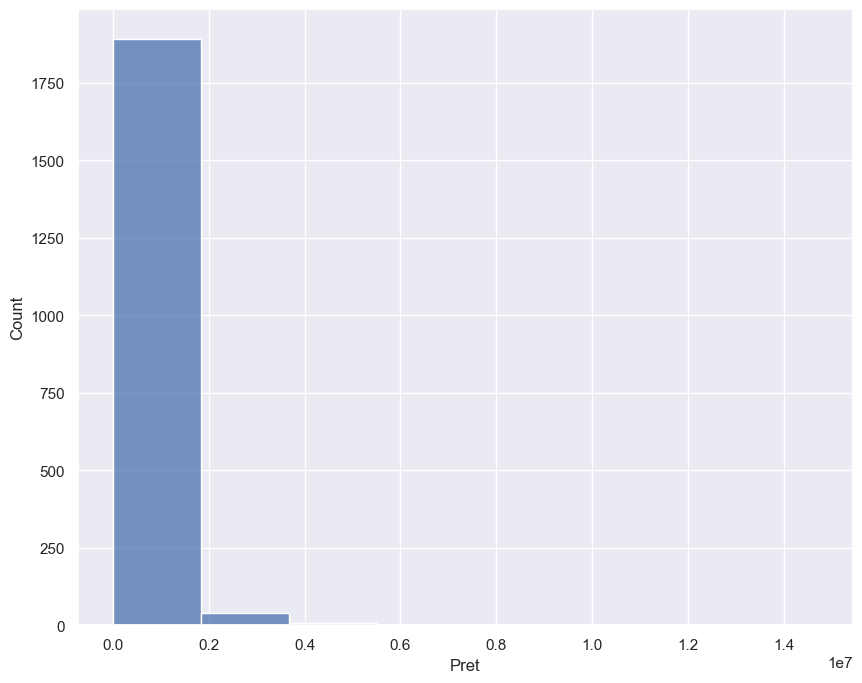

In [43]:
sns.histplot(df['Pret'], kde=False, bins=8)

<Axes: xlabel='Suprafață', ylabel='Pret'>

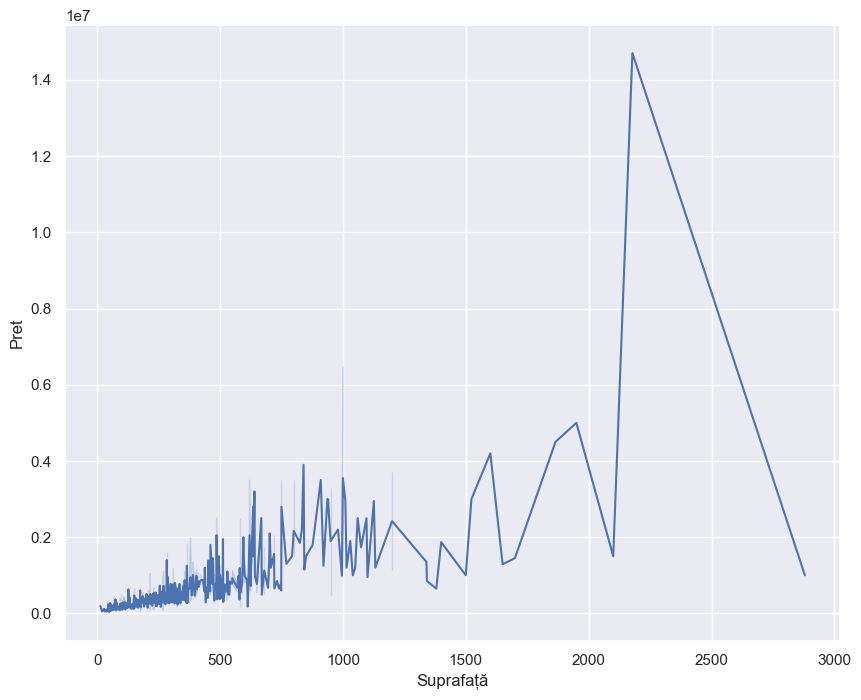

In [32]:
sns.lineplot(x="Suprafață", y="Pret", data=df)

<Axes: xlabel='Pret', ylabel='Tip încălzire'>

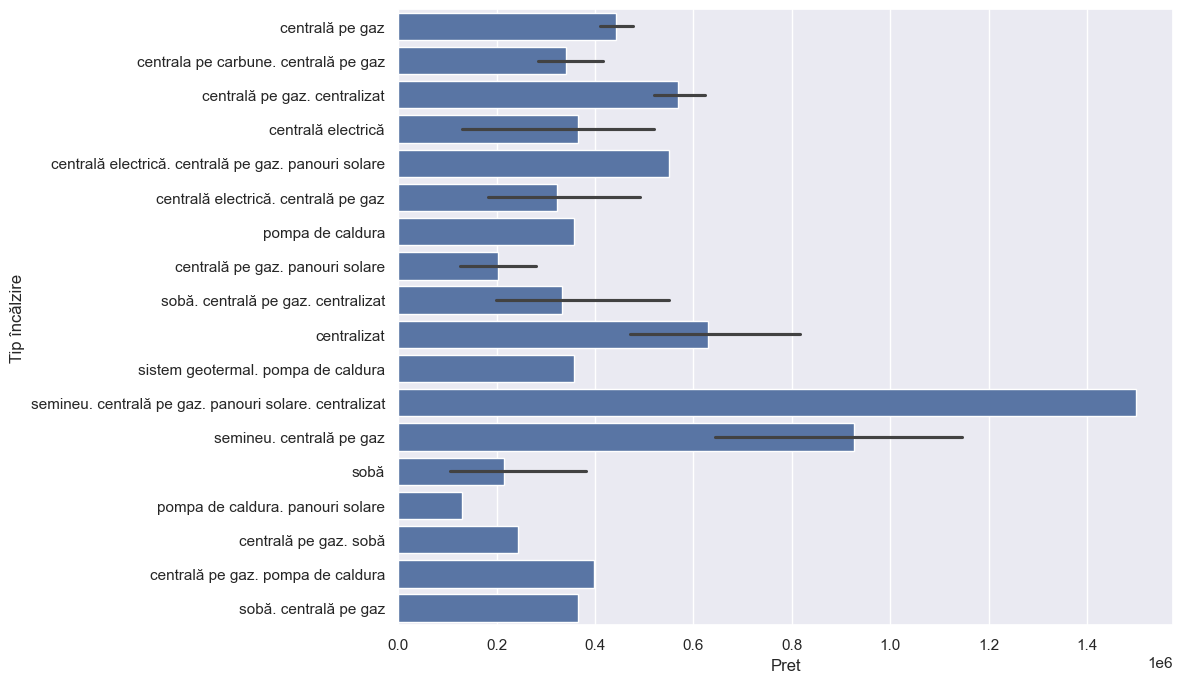

In [74]:
sns.barplot(x="Pret", y="Tip încălzire", data=df)

(0.0, 3500.0)

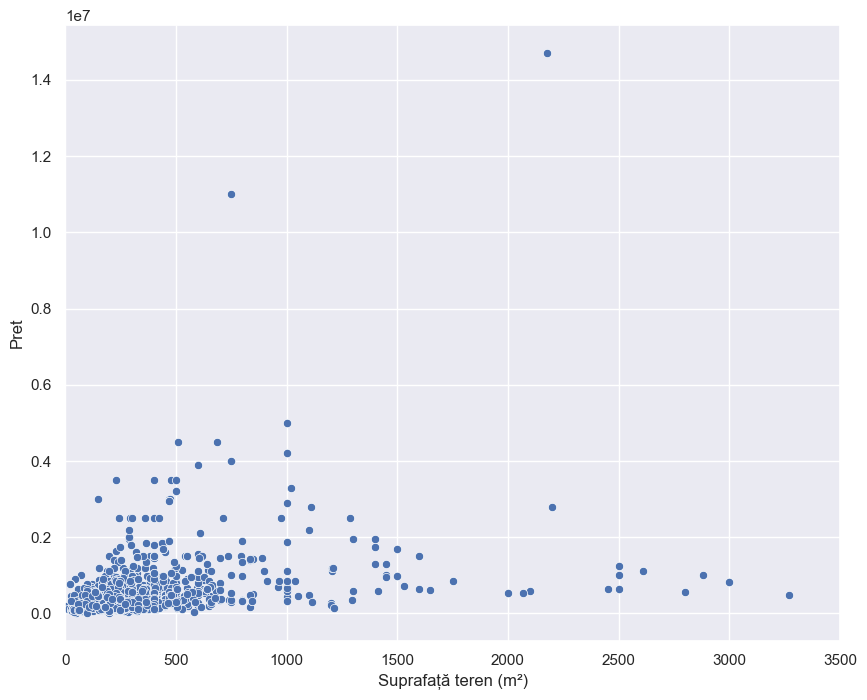

In [75]:
sns.scatterplot(x="Suprafață teren (m²)", y="Pret", data=df)
plt.xlim(0, 3500)

<Axes: xlabel='Pret', ylabel='Stare'>

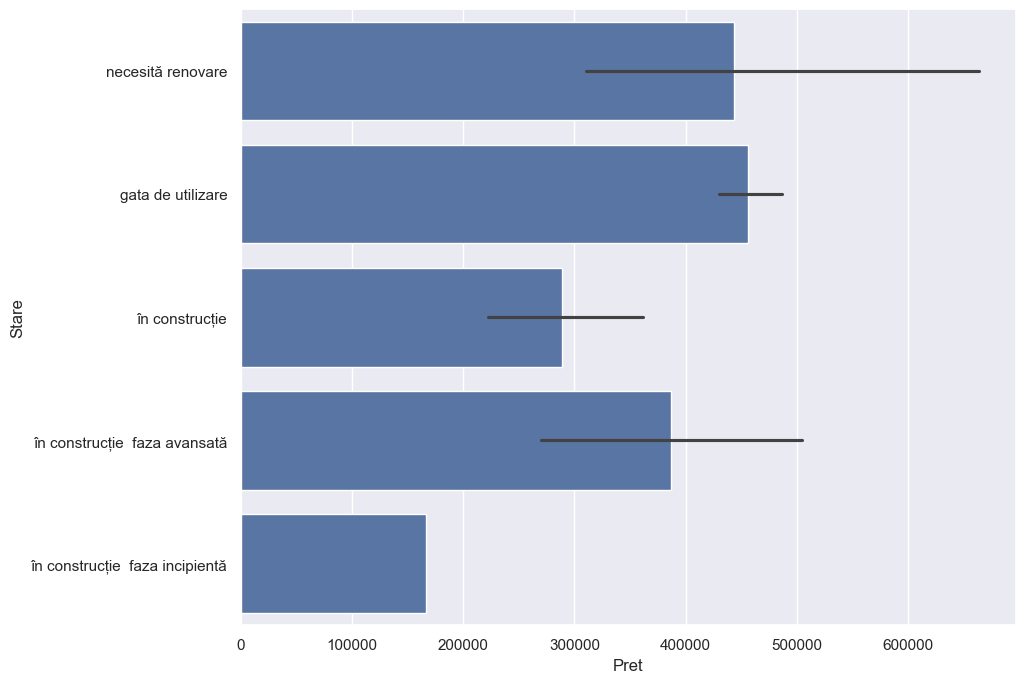

In [76]:
sns.barplot(x="Pret", y="Stare", data=df)

<Axes: xlabel='Tip clădire', ylabel='Pret'>

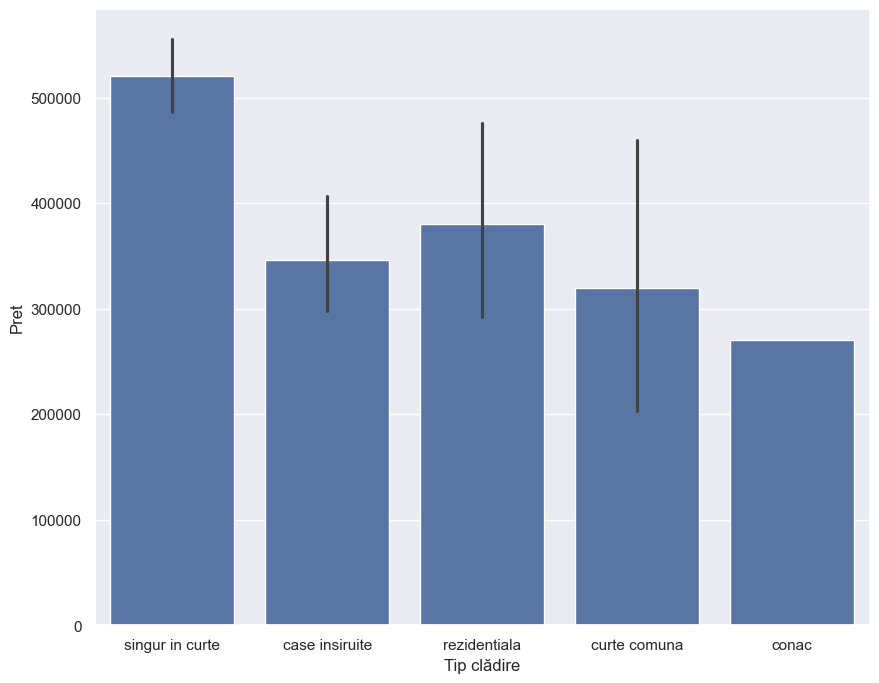

In [77]:
sns.barplot(x="Tip clădire", y="Pret", data=df)

(1850.0, 2050.0)

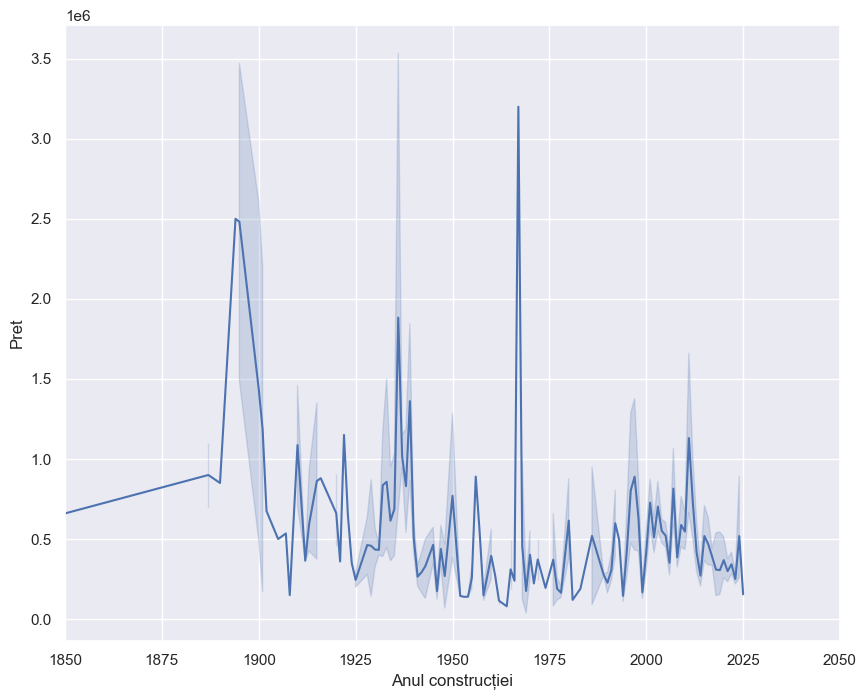

In [78]:
x = sns.lineplot(x="Anul construcției", y="Pret", data=df)
plt.xlim(1850, 2050)

<Axes: xlabel='Numărul de camere', ylabel='Pret'>

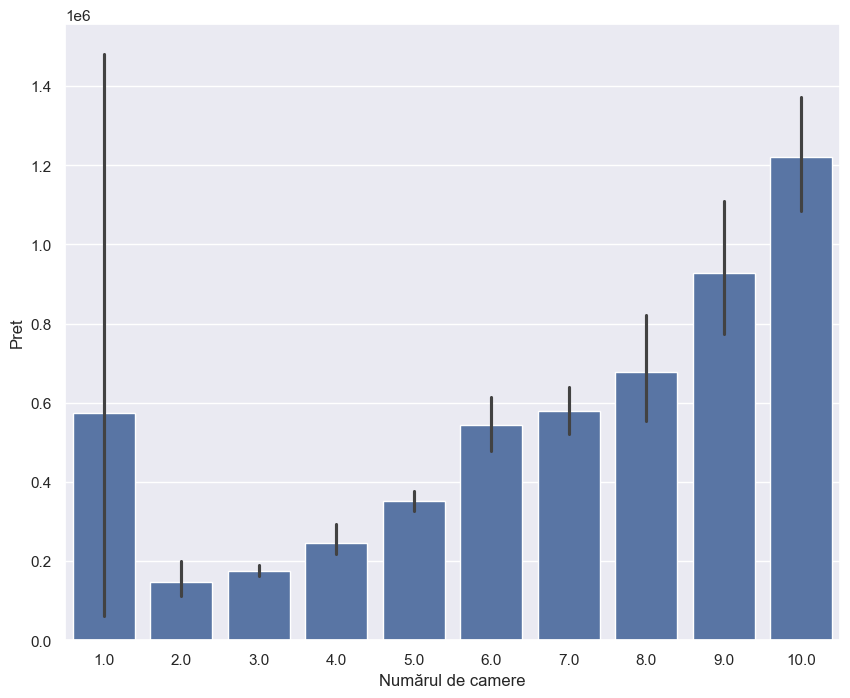

In [79]:
sns.barplot(x="Numărul de camere", y="Pret", data=df)

<Axes: xlabel='Garaj/loc de parcare', ylabel='Pret'>

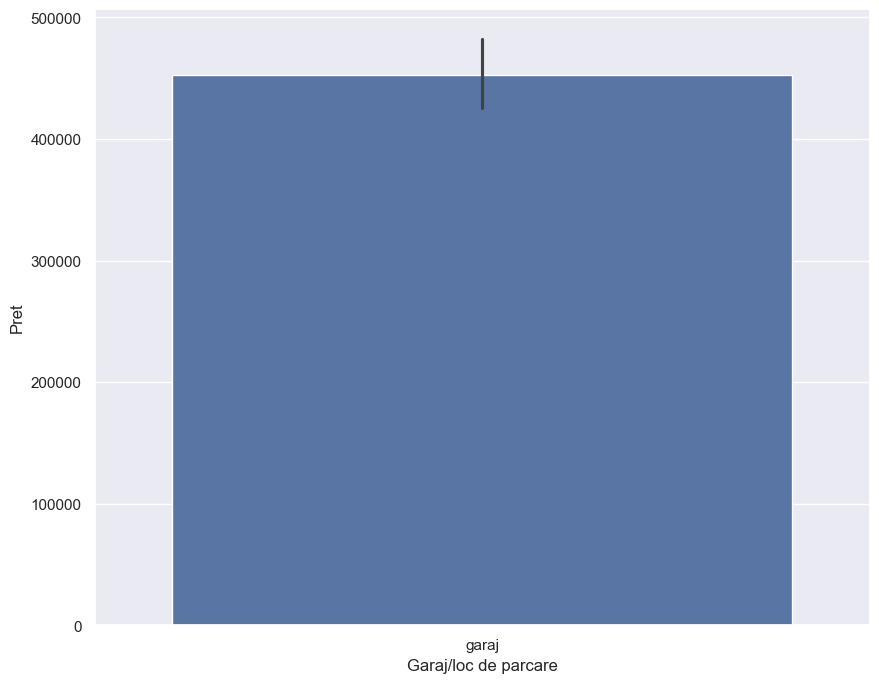

In [80]:
sns.barplot(x="Garaj/loc de parcare", y="Pret", data=df)

<Axes: xlabel='Tip proprietate', ylabel='Pret'>

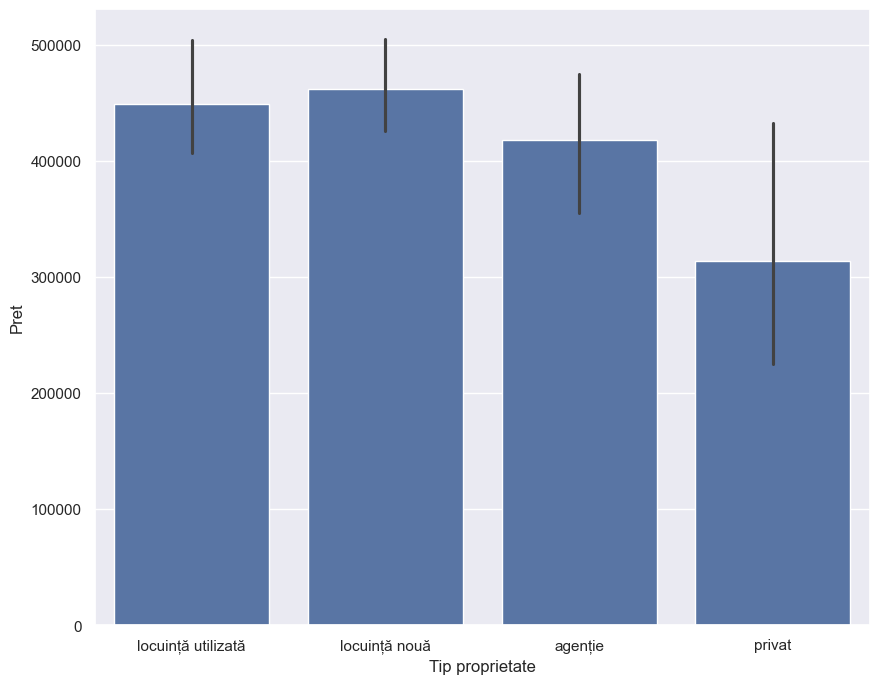

In [81]:
sns.barplot(x="Tip proprietate", y="Pret", data=df)

<Axes: xlabel='Pret', ylabel='Material de construcție'>

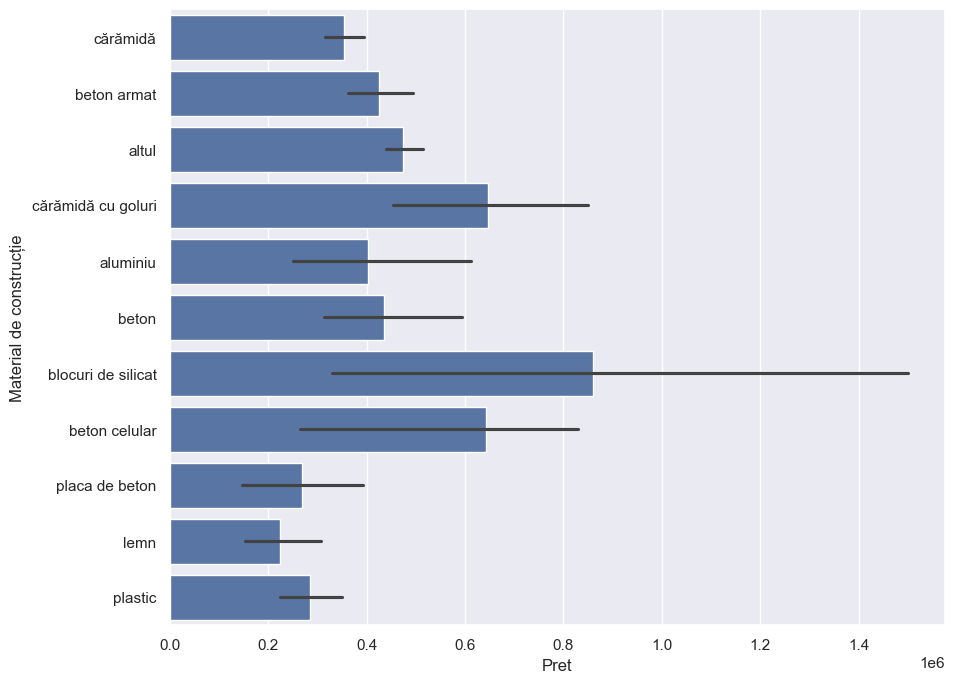

In [83]:
sns.barplot(x="Pret", y="Material de construcție", data=df)

<Axes: xlabel='Numar de etaje', ylabel='Pret'>

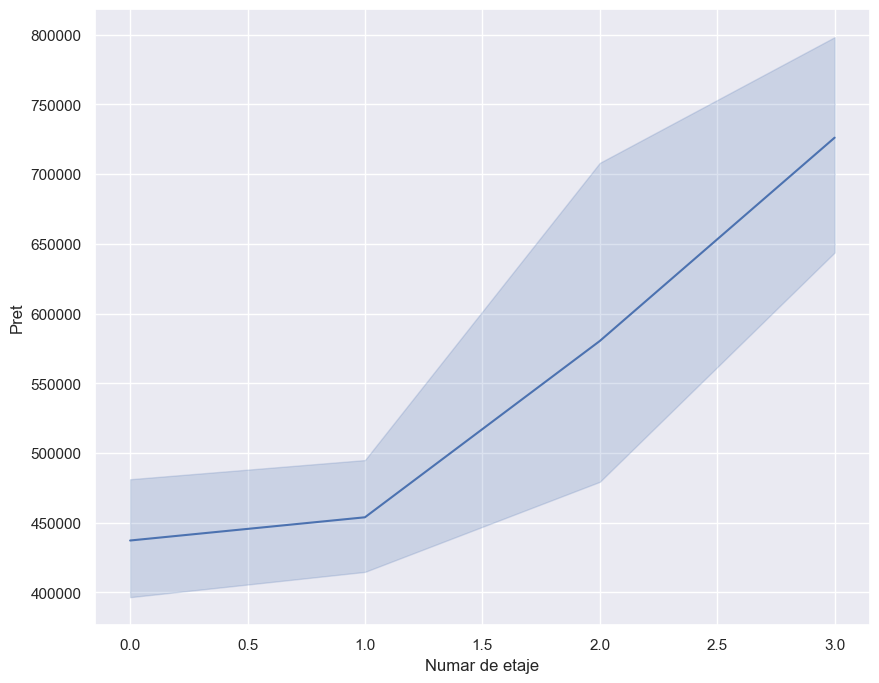

In [84]:
sns.lineplot(x="Numar de etaje", y="Pret", data=df)

<Axes: xlabel='Tip acoperis', ylabel='Pret'>

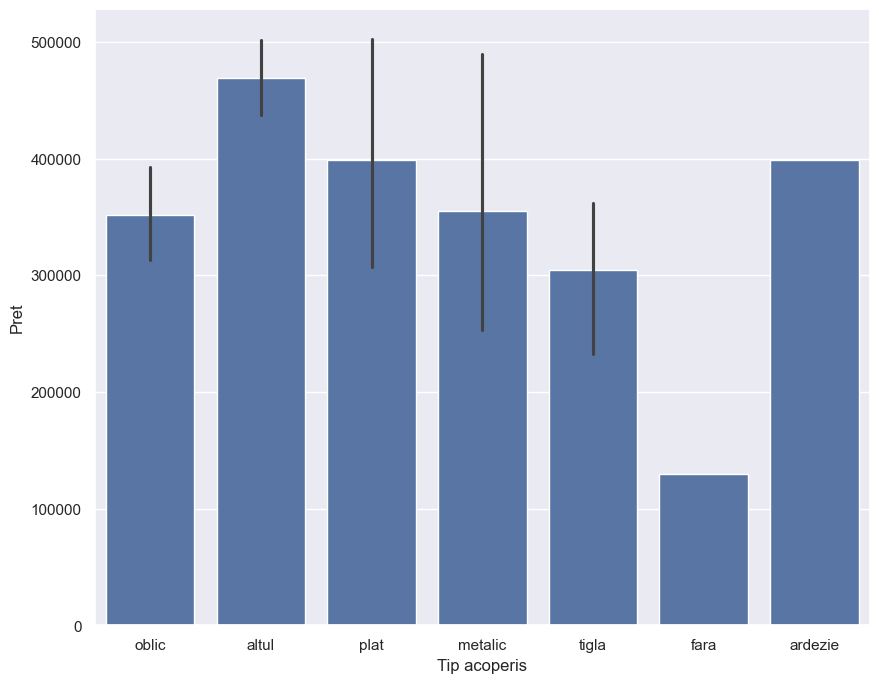

In [85]:
sns.barplot(x="Tip acoperis", y="Pret", data=df)

<Axes: xlabel='Acoperis', ylabel='Pret'>

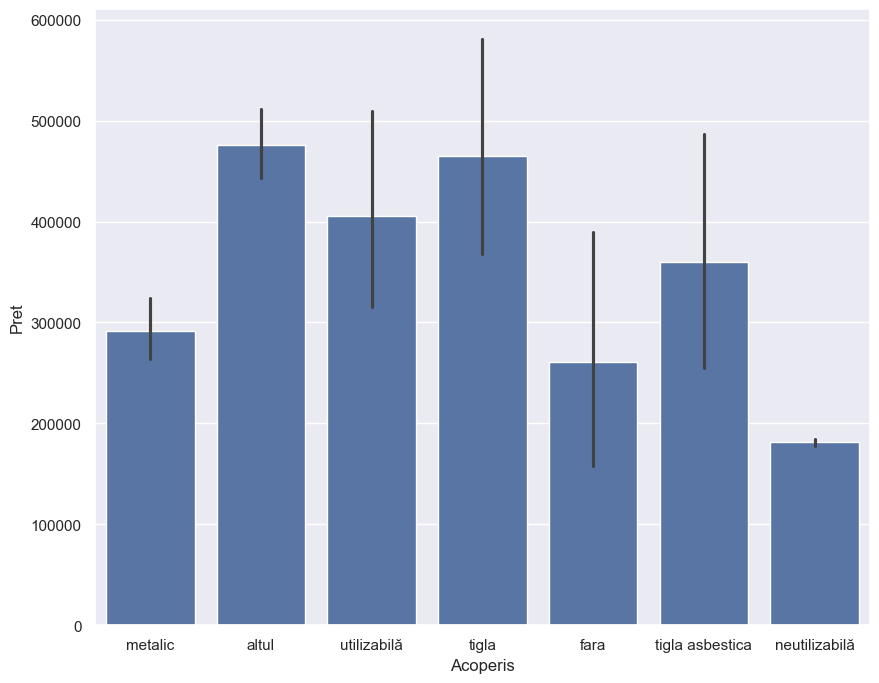

In [86]:
sns.barplot(x="Acoperis", y="Pret", data=df)

<Axes: xlabel='Tip mansardă', ylabel='Pret'>

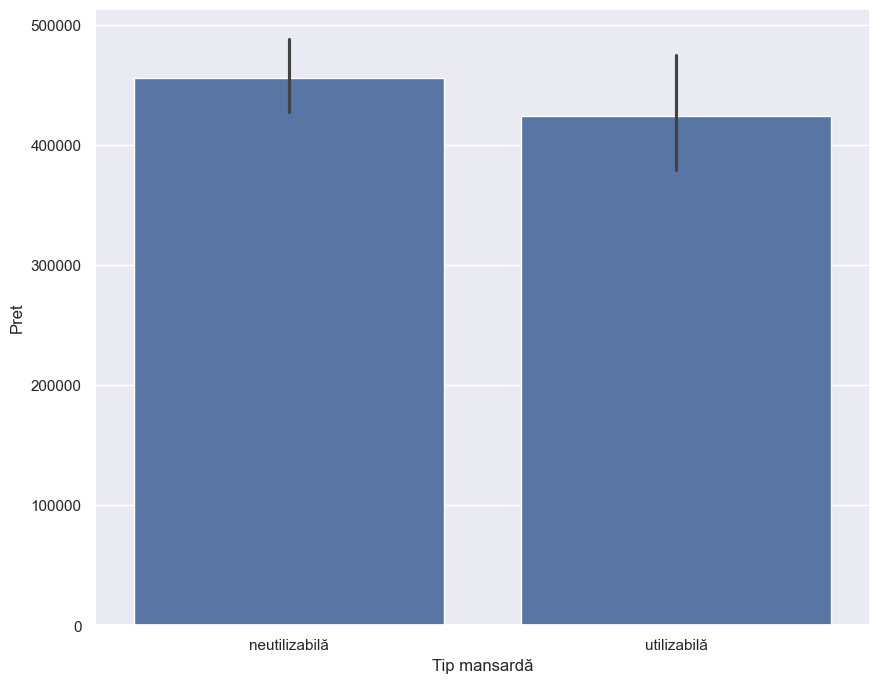

In [87]:
sns.barplot(x="Tip mansardă", y="Pret", data=df)

<Axes: xlabel='Pret', ylabel='Tip acces'>

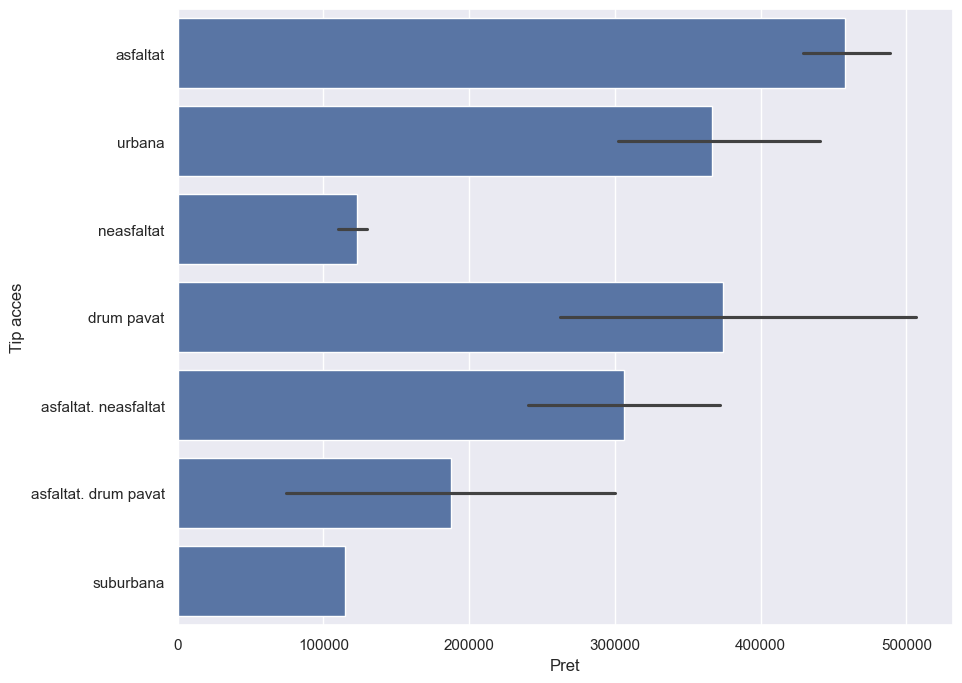

In [89]:
sns.barplot(x="Pret", y="Tip acces", data=df)

<Axes: xlabel='Locație', ylabel='Pret'>

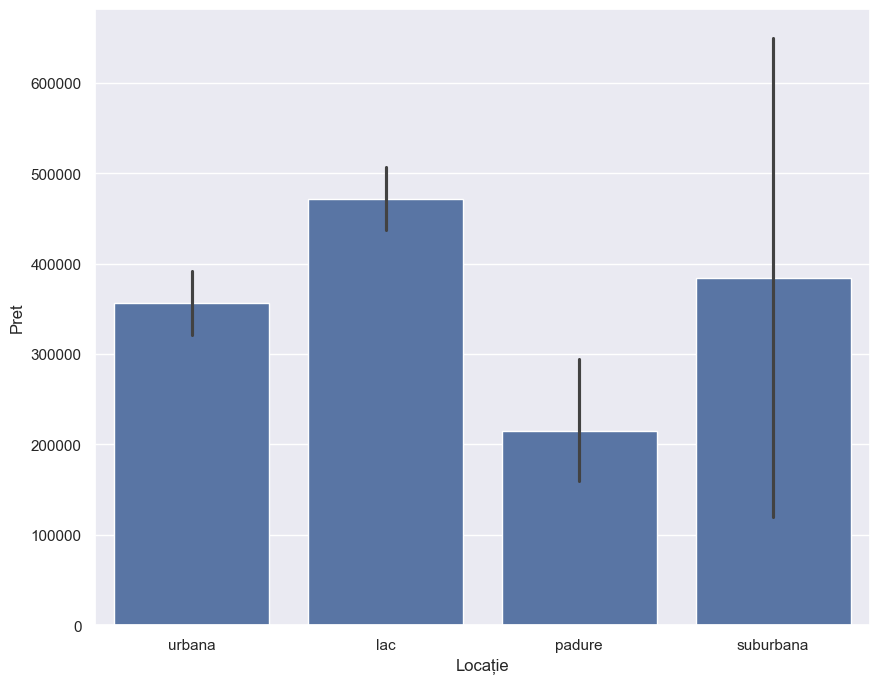

In [90]:
sns.barplot(x="Locație", y="Pret", data=df)

<Axes: xlabel='Aer condiționat', ylabel='Pret'>

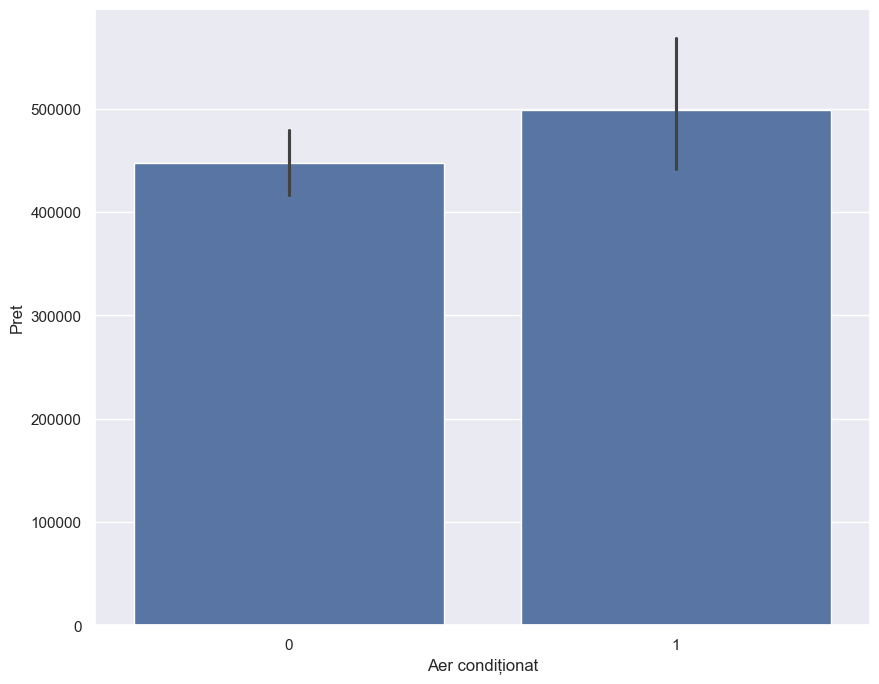

In [91]:
sns.barplot(x="Aer condiționat", y="Pret", data=df)